# Evaluation of classifiers for ACM ASIACC paper

128-feature vector

## Loading data and selecting features of interest

In [29]:
import pyarrow as pa
import pyarrow.parquet as pq

#phishing = pq.read_table('floor/phishing_2307.parquet')
phishing = pq.read_table('floor/phishing_2311.parquet')
benign = pq.read_table('floor/benign_2310.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ACM ASIACCS
    "ip_v4_ratio",
    #"ip_a_aaaa_to_all_ratio", <--- not useful for this dataset
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    #"dns_SOA_count", <-- REMOVED, very low effect -------------------------------------
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ACM ASIACCS
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_is_self_signed", # <--- NEW (23-12-02)
    "tls_root_authority_hash", # <--- NEW (23-12-02)
    "tls_leaf_authority_hash", # <--- NEW (23-12-02)
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    #"tls_root_cert_lifetime", <---- NO!
    #"tls_leaf_cert_lifetime", <---- NO!
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ACM ASIACCS
    #"tls_has_tls", , <-- REMOVED, very low effect -------------------------------------
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_tld_abuse_score", # *************************************************************
    "lex_tld_hash", # *************************************************************
    
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 23-09-29
    # ============================= New SLD features 23-11
    "lex_sld_phishing_keyword_count",
    #"lex_sld_digit_count",
    #"lex_sld_digit_ratio",
    "lex_sld_vowel_count",
    "lex_sld_vowel_ratio",
    "lex_sld_consonant_count",
    "lex_sld_consonant_ratio",
    "lex_sld_non_alphanum_count",
    "lex_sld_non_alphanum_ratio",
    "lex_sld_hex_count",
    "lex_sld_hex_ratio",
    # =============================      
    
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",

    #"lex_bigram_matches",  # OLD NAME
    #"lex_trigram_matches", # OLD NAME
    "lex_phishing_bigram_matches",  # NEW NAME
    "lex_phishing_trigram_matches", # NEW NAME
    "lex_phishing_tetragram_matches", # *************************************************************
    "lex_phishing_pentagram_matches", # *************************************************************
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ACM ASIACCS
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ACM ASIACCS
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev",  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.    
    #"geo_min_lat", # not very useful
    #"geo_max_lat", # not very useful
    #"geo_min_lon", # not very useful
    #"geo_max_lon", # not very useful
    "geo_mean_lat", # *************************************************************
    "geo_mean_lon", # *************************************************************
    #"geo_lat_range", # not very useful
    #"geo_lon_range", # not very useful
    "geo_centroid_lat", # *************************************************************
    "geo_centroid_lon", # *************************************************************
    #"geo_estimated_area",  # not very useful 
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 500925
Number of used features: 143
No. of available unused features: 36


## Subsampling entire dataset (for testing purposes only!)

In [30]:
#subsample = 0.15 # 1.0 means no subsample
subsample = 1.0 # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings (futures etc.)

In [31]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

## Shortening feature names (for paper purposes)

In [32]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    "lex_phishing_keyword_count": "lex_phishing_kw_count",
    "lex_sld_phishing_keyword_count": "lex_sld_phishing_kw_count",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

,label,ip_mean_average_rtt,ip_entropy,ip_count,ip_v4_ratio,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,dns_A_count,dns_AAAA_count,...,rdap_ip_avg_admin_email_ent,geo_countries_count,geo_continent_hash,geo_countries_hash,geo_lat_stdev,geo_lon_stdev,geo_mean_lat,geo_mean_lon,geo_centroid_lat,geo_centroid_lon
363070,benign_2310:unknown,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.000000e+00,0.000000,0.00000,0.00000,0.00000,0.00000
138997,benign_2310:unknown,0.440500,-0.000000,2,1.0,-0.000000,-0.000000,1.0,2,0,...,0.000000,1,3,45,0.000000e+00,0.000000,50.08530,14.41100,75.12795,21.61650
440343,benign_2310:unknown,9.989167,3.000000,12,0.0,-0.000000,-0.000000,1.0,0,0,...,0.149881,1,1,187,7.105427e-15,0.000000,37.75100,-97.82200,56.62650,-146.73300
479470,benign_2310:unknown,14.995000,-0.000000,4,0.0,-0.000000,-0.000000,1.0,0,0,...,0.000000,1,3,45,0.000000e+00,0.000000,50.08830,14.41240,75.13245,21.61860
448966,benign_2310:unknown,2.907667,1.891061,9,1.0,1.891061,1.224394,3.0,1,0,...,0.179935,1,1,187,0.000000e+00,0.000000,37.75100,-97.82200,56.62650,-146.73300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195478,benign_2310:unknown,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.175700,1,1,187,0.000000e+00,0.000000,37.18350,-121.77140,55.77525,-182.65710
315407,benign_2310:unknown,9.319600,0.970951,5,1.0,0.970951,0.970951,2.0,1,0,...,0.055590,3,3,940,3.600300e+00,13.035344,57.25058,14.68832,78.56385,-9.38865
380063,benign_2310:unknown,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.191096,1,1,187,0.000000e+00,0.000000,26.21540,-80.27100,39.32310,-120.40650
434443,benign_2310:unknown,8.209000,-0.000000,2,0.0,-0.000000,-0.000000,1.0,0,0,...,0.135512,2,4,504,6.774150e+00,53.656500,44.52515,-44.16550,56.62650,-146.73300


# NaNs will be replaced by -1 (best results)

In [33]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test Split

In [34]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Logistic Regression

In [35]:
import warnings
import inspect
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Filter out specific FutureWarnings from scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

def run_logistic_regression_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": [],
        "TPR": []
    }

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(X_train)
    x_test_scaled = scaler.transform(X_test)

    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        params = {
            "C": 30,  # Regularization parameter (default: 1.0)
            "penalty": "l2",  # (default: l2)
            "max_iter": 3500,  # Maximum number of iterations (default: 100)
            "solver": "liblinear",
            "random_state": seed * 42
        }
        

        model = LogisticRegression(**params)
        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        tpr = recall  # TPR is the same as Recall

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        results["TPR"].append(tpr)
        
        if verbose:
            print("Seed {seed} done.")
    
    return results


# SVM

In [76]:
import warnings
import inspect
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import copy

# Filter out specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

def run_svm_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": [],
        "TPR": []
    }
    

    svm_x_train = copy.deepcopy(X_train)
    svm_x_test = copy.deepcopy(X_test)

    svm_y_train = copy.deepcopy(y_train)
    svm_y_test = copy.deepcopy(y_test)


    subsample = 0.1  # Subsample < 1.0 for TESTING PURPOSES ONLY!
    if subsample < 1.0:
        svm_x_train, _, svm_y_train, _ = train_test_split(
            svm_x_train,
            svm_y_train,
            test_size=1.0 - subsample,
            random_state=42,
            shuffle=True,
            stratify=svm_y_train
        )

        # Check the number of samples after subsampling
        print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")

    # PREPROCESSING
    # fill nans with 0 in X_train and X_test and y_train and y_test
    svm_x_train = svm_x_train.fillna(0)
    svm_x_test = svm_x_test.fillna(0)

    svm_y_train = svm_y_train.fillna(0)
    svm_y_test = svm_y_test.fillna(0)

    # convert x_train to numpy array
    svm_x_train = svm_x_train.to_numpy()
    svm_x_test = svm_x_test.to_numpy()

    svm_y_train = svm_y_train.to_numpy()
    svm_y_test = svm_y_test.to_numpy()

    # Converting False and True to 0 and 1
    svm_x_train = np.where(svm_x_train == False, 0, svm_x_train)
    svm_x_train = np.where(svm_x_train == True, 1, svm_x_train)

    svm_x_test = np.where(svm_x_test == False, 0, svm_x_test)
    svm_x_test = np.where(svm_x_test == True, 1, svm_x_test)

    #feature_count = svm_x_train.shape[1]
    #sample_count = svm_x_train.shape[0]
    
    
    # MinMax data scaler
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(svm_x_train)
    x_test_scaled = scaler.transform(svm_x_test)

    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        # Shuffle and subsample training data for this seed
        svm_x_train_shuffled, _, svm_y_train_shuffled, _ = train_test_split(
            x_train_scaled,
            svm_y_train,
            test_size=0.0,
            random_state=seed * 42,
            shuffle=True,
            stratify=svm_y_train
        )

        params = {
            "C": 59,
            "gamma": 0.1,
            "kernel": "rbf",  # ['rbf', 'linear', 'poly', 'sigmoid']
            "random_state": seed * 42,
            "shrinking": True,
            "verbose": False  # Set to False to avoid excessive output
        }

        model = SVC(**params)
        model.fit(svm_x_train_shuffled, svm_y_train_shuffled)
        y_pred = model.predict(x_test_scaled)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        tpr = recall  # TPR is the same as Recall

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        results["TPR"].append(tpr)
        
        if verbose:
            print(f"Seed {seed} done.")

    return results


# Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def run_decision_tree_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                                     display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": [],
        "TPR": []
    }
    
    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        params = {
            "max_depth": 30,
            "max_leaf_nodes": 803,
            "min_samples_leaf": 1,
            "min_samples_split": 5,
            "random_state": seed * 42
        }

        model = DecisionTreeClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        tpr = recall  # TPR is the same as Recall

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        results["TPR"].append(tpr)
        
        if verbose:
            print("Seed {seed} done.")
    
    return results


# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def run_random_forest_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                                     display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": [],
        "TPR": []
    }
    
    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        # Random Forest parameters with variable seed
        params = {
            "n_estimators": 143,
            "criterion": 'entropy',
            #"max_depth": 19,
            "max_depth": 17,
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "max_leaf_nodes": 174,
            "random_state": seed * 42
        }

        # Create and train the model
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        tpr = recall  # TPR is the same as Recall

        results["Accuracy"].append(accuracy) # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        results["TPR"].append(tpr)
        
        if verbose:
            print("Seed {seed} done.")
    
    return results


# AdaBoost

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def run_adaboost_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                                display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": [],
        "TPR": []
    }
    
    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        dt_params = {
            "max_depth": 3,
            "min_samples_leaf": 1,
            "min_samples_split": 5,
            "random_state": seed * 42
        }    
        
        # AdaBoost parameters with variable seed
        params = {
            "base_estimator": DecisionTreeClassifier(**dt_params),  #  base estimator
            "n_estimators": 320,  # Number of weak learners to train iteratively
            "random_state": seed * 42
        }

        # Create and train the model
        model = AdaBoostClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        tpr = recall  # TPR is the same as Recall

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        results["TPR"].append(tpr)
        
        # Optionally display confusion matrix
        if display_cm:
            cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()
            
        if display_graphs:
            pass
        
        if verbose:
            print("Seed {seed} done.")
    
    return results


# XGBoost

In [40]:
import warnings

# Suppress specific FutureWarnings from XGBoost
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
# Suppress specific FutureWarnings from Sklearn
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import pickle


def run_xgb_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }

    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        params = {
            "objective": "binary:logistic",
            "tree_method": "gpu_hist",
            "sampling_method": "gradient_based",
            "max_depth": 8,
            "eta": 0.15,
            "min_child_weight": 2.0,
            "subsample": 0.6,
            "alpha": 0,
            "gamma": 0.1,
            "lambda": 1.0,
            "max_delta_step": 0,
            "grow_policy": "depthwise",
            "max_bin": 512,
            "n_estimators": 550,
            "random_state": seed * 42  # Set the seed for each run
        }
        model = XGBClassifier(
            **params,
            eval_metric=["error", "logloss", "auc"]
        )

        eval_set = [(X_train, y_train), (X_test, y_test)]
        model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

        # Calculate metrics
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy) # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)

        # Optionally print confusion matrix
        if display_cm:
            print(f"Confusion Matrix for Seed {seed}:\n", confusion_matrix(y_test, y_pred))

        # Optionally display graphs
        if display_graphs:
            # Extract and plot metrics from eval_set results
            # plot evaluation
            results = model.evals_result()
            trees = len(results['validation_0']['error'])
            x_axis = range(0, trees)

            def plot_metric(metric):
                import matplotlib.pyplot as plt
                plt.rcParams["figure.dpi"] = 300
                #
                plt.plot(x_axis, results['validation_0'][metric], label='Training set')
                plt.plot(x_axis, results['validation_1'][metric], label='Testing set')
                plt.legend()
                mnames = {'error': 'Classification Error', 'logloss': 'Log Loss', 'auc': 'AUC'}
                mname = mnames[metric]
                plt.ylabel(mname)
                plt.xlabel('Number of trees')
                plt.title('XGBoost ' + mname)
                plt.show()

            plot_metric('error')
            plot_metric('logloss')
            plot_metric('auc')
            
        if verbose:
            print("Seed {seed} done.")

    return results


# LightGBM

In [86]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

def run_lgb_multiple_seeds(n_seeds, X_train, y_train, X_test, y_test,
                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    for seed in range(n_seeds):
        if verbose:
            print(f"Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        # LightGBM parameters with variable seed        
        params = {
            "objective": "binary",  # binary classification
            "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
            "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
            "num_leaves": 59,
            "max_depth": 17,
            "learning_rate": 0.15,
            "objective": "binary",
            "min_child_samples": 27,
            "colsample_bytree": 0.9,
            "reg_lambda": 0.11,
            "scale_pos_weight": 1.1, # default: 1.0
            "subsample_for_bin": 240000,
            "random_state": 7,
        }

        # Create and train the model
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        # Save the model if needed
        model_filename = f"lightgbm_model_seed_{seed}.pickle.dat"
        pickle.dump(model, open(model_filename, "wb"))

        # Predictions
        y_pred = model.predict(X_test)
        
         # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
       
        # Compute metrics
        results["Accuracy"].append(accuracy_score(y_test, y_pred)) # only makes sense for balanced datasets
        results["Precision"].append(precision_score(y_test, y_pred, zero_division=1))
        results["Recall"].append(recall_score(y_test, y_pred))
        results["F1"].append(f1_score(y_test, y_pred))
        results["FPR"].append(fpr)

        # Optionally display confusion matrix
        if display_cm:
            cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()
            
        if display_graphs:
            pass
        
        if verbose:
            print("Seed {seed} done.")

    return results


# Run evaluations

## Initialize results

In [42]:
replace_results_if_nonempty = False

In [43]:
try:
    if isinstance(my_variable, dict):
        if len(results) > 0 and replace_results_if_nonempty:
            results = dict()
    else:
        results = dict()
except NameError:
    results = dict()


## Run

In [77]:
import datetime
import time

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Run the function with the desired number of seeds and store the results in the dictionary
results['Logistic Regression'] = run_logistic_regression_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['SVM'] = run_svm_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['DecisionTree'] = run_decision_tree_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['RandomForest'] = run_random_forest_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['AdaBoost'] = run_adaboost_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['XGBoost'] = run_xgb_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
results['LightGBM'] = run_lgb_multiple_seeds(10, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")

Seed 0: run_adaboost_multiple_seeds() Running...
Seed {seed} done.
Seed 1: run_adaboost_multiple_seeds() Running...
Seed {seed} done.


# Display results and produce outputs

## Raw data display

In [80]:
results

{'Logistic Regression': {'Accuracy': [0.9635790967970899,
   0.9635790967970899,
   0.9635790967970899],
  'Precision': [0.9044883303411131, 0.9044883303411131, 0.9044883303411131],
  'Recall': [0.8194534808067664, 0.8194534808067664, 0.8194534808067664],
  'F1': [0.8598736985833759, 0.8598736985833759, 0.8598736985833759],
  'FPR': [0.013663447709061024, 0.013663447709061024, 0.013663447709061024],
  'TPR': [0.8194534808067664, 0.8194534808067664, 0.8194534808067664]},
 'SVM': {'Accuracy': [0.9392245586017213,
   0.9457900807381776,
   0.9427291278502351,
   0.9382042409724071],
  'Precision': [0.7760855476344782,
   0.8561538461538462,
   0.8631364562118127,
   0.8256489732661759],
  'Recall': [0.7791151594014314,
   0.7241379310344828,
   0.6893298633702017,
   0.6932335718932986],
  'F1': [0.7775974025974027,
   0.7846316531547409,
   0.766503888587448,
   0.7536693191865607],
  'FPR': [0.03549414423669612,
   0.019211012944318883,
   0.01725909184302445,
   0.023114855146907747],


## Draw table with averages and variances

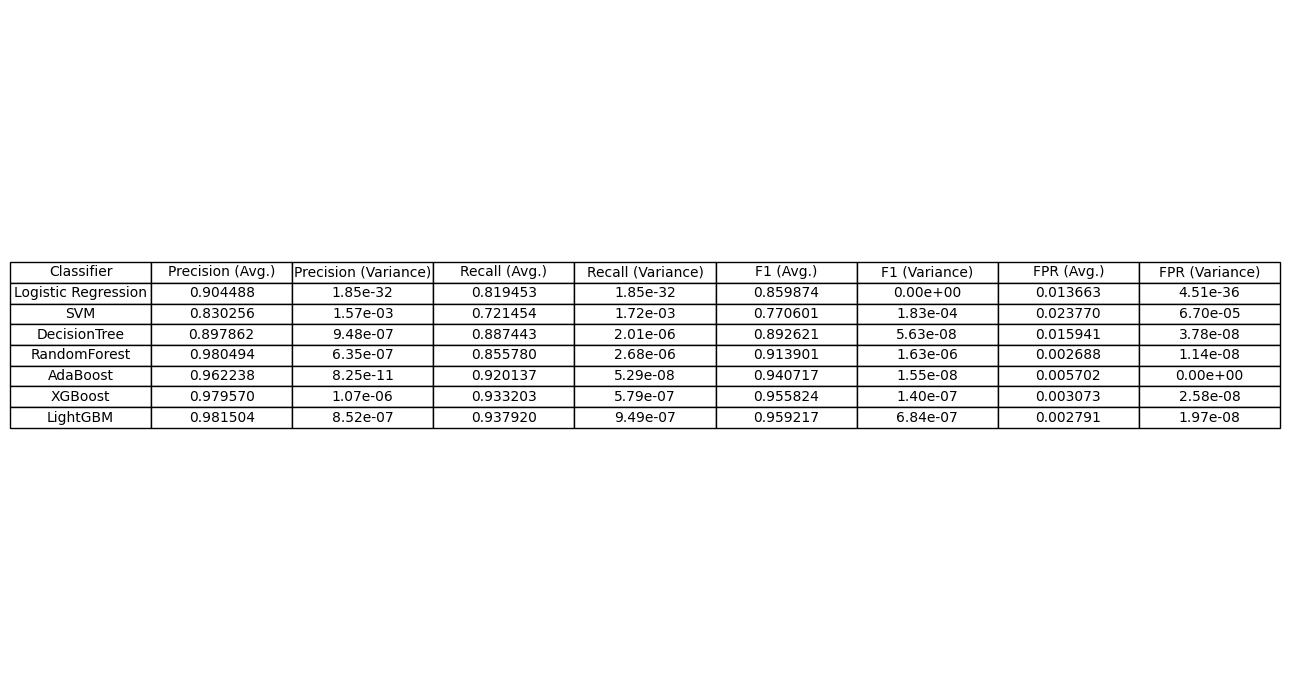

'table_with_variances.png'

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_averages_and_variances(results):
    stats = {}
    for classifier, metrics in results.items():
        stats[classifier] = {}
        for metric, values in metrics.items():
            avg = np.mean(values)
            var = np.var(values, ddof=1)  # Unbiased estimator, using sample variance
            stats[classifier][metric] = {'average': avg, 'variance': var}
    return stats

def draw_table_with_variances(stats):
    # Define the metrics
    metrics = ['Precision', 'Recall', 'F1', 'FPR']
    # Create headers for the table: 'Metric (Avg.)' followed by 'Metric (Variance)'
    headers = ['Classifier']
    for metric in metrics:
        headers.extend([f'{metric} (Avg.)', f'{metric} (Variance)'])
    
    # Create the table data structure
    cell_text = [headers]
    
    # Fill in the data rows
    for classifier, metrics_data in stats.items():
        row = [classifier]
        for metric in metrics:
            avg = metrics_data[metric]['average']
            var = metrics_data[metric]['variance']
            row.extend([f"{avg:.6f}", f"{var:.2e}"])
        cell_text.append(row)

    # Determine the figure width dynamically: base_width + (num_columns * width_per_column)
    num_columns = len(headers)
    width_per_column = 1.0  # starting point for width per column, may need adjustment
    base_width = 4  # base width to account for the first column which typically needs more space
    fig_width = base_width + (num_columns * width_per_column)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, 2 + 0.625 * len(cell_text)))  # Adjust the size as needed
    ax.axis('off')  # Hide the axes

    # Create the table and adjust the layout
    table = ax.table(cellText=cell_text, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    plt.tight_layout()
    return fig

# Calculate averages and variances
stats = calculate_averages_and_variances(results)

# Draw the table with variances
fig = draw_table_with_variances(stats)

# Save the figure to a file and show it
output_file = "table_with_variances.png"
fig.savefig(output_file)
plt.show()

# Return the path to the saved figure
output_file


## Generate LaTeX tabular code

In [82]:
def generate_latex_tabular(stats):
    # Define the metrics
    metrics = ['Precision', 'Recall', 'F1', 'FPR']
    
    # Find the highest average for each metric except for FPR, where we find the lowest
    highest_avg = {metric: max(metrics_data[metric]['average'] for metrics_data in stats.values()) for metric in metrics if metric != 'FPR'}
    lowest_fpr = min(stats[classifier]['FPR']['average'] for classifier in stats)
    
    # Initialize the LaTeX table string
    latex_table = "\\begin{tabular}{|l|" + "c|c|" * len(metrics) + "}\n\\hline\n"
    
    # Create the header row with multicolumns for average and variance
    latex_table += " & " + " & ".join([f"\\multicolumn{{2}}{{c|}}{{\\textbf{{{metric}}}}}" for metric in metrics]) + " \\\\\n"
    latex_table += "\\hline\n"
    latex_table += "\\textbf{Classifier} & " + " & ".join(["Avg. & Variance" for _ in metrics]) + " \\\\\n\\hline\n"
    
    # Fill in the data rows
    for classifier, metrics_data in stats.items():
        row = [classifier.replace('_', '\\_')]  # Escape underscores for LaTeX
        for metric in metrics:
            avg = metrics_data[metric]['average']
            # Bold the highest average or the lowest FPR
            if metric == 'FPR':
                avg_str = f"\\textbf{{{avg:.6f}}}" if avg == lowest_fpr else f"{avg:.6f}"
            else:
                avg_str = f"\\textbf{{{avg:.6f}}}" if avg == highest_avg.get(metric, None) else f"{avg:.6f}"
            var = metrics_data[metric]['variance']
            # Display variance in scientific notation
            var_str = "{:.2e}".format(var) if var > 0 else "0.00e+00"
            row.extend([avg_str, var_str])
        latex_table += " & ".join(row) + " \\\\\n\\hline\n"
    
    # Close the LaTeX table string
    latex_table += "\\end{tabular}"
    
    return latex_table

# Calculate averages and variances
stats = calculate_averages_and_variances(results)

# Generate LaTeX tabular code for the table
latex_tabular_code = generate_latex_tabular(stats)
print(latex_tabular_code)

# Save the LaTeX code to a file
output_file = "table_with_variances.tex"
with open(output_file, "w") as f:
    f.write(latex_tabular_code)

# Return the path to the saved LaTeX file
output_file


\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
\hline
 & \multicolumn{2}{c|}{\textbf{Precision}} & \multicolumn{2}{c|}{\textbf{Recall}} & \multicolumn{2}{c|}{\textbf{F1}} & \multicolumn{2}{c|}{\textbf{FPR}} \\
\hline
\textbf{Classifier} & Avg. & Variance & Avg. & Variance & Avg. & Variance & Avg. & Variance \\
\hline
Logistic Regression & 0.904488 & 1.85e-32 & 0.819453 & 1.85e-32 & 0.859874 & 0.00e+00 & 0.013663 & 4.51e-36 \\
\hline
SVM & 0.830256 & 1.57e-03 & 0.721454 & 1.72e-03 & 0.770601 & 1.83e-04 & 0.023770 & 6.70e-05 \\
\hline
DecisionTree & 0.897862 & 9.48e-07 & 0.887443 & 2.01e-06 & 0.892621 & 5.63e-08 & 0.015941 & 3.78e-08 \\
\hline
RandomForest & 0.980494 & 6.35e-07 & 0.855780 & 2.68e-06 & 0.913901 & 1.63e-06 & \textbf{0.002688} & 1.14e-08 \\
\hline
AdaBoost & 0.962238 & 8.25e-11 & 0.920137 & 5.29e-08 & 0.940717 & 1.55e-08 & 0.005702 & 0.00e+00 \\
\hline
XGBoost & 0.979570 & 1.07e-06 & 0.933203 & 5.79e-07 & 0.955824 & 1.40e-07 & 0.003073 & 2.58e-08 \\
\hline
LightGBM & \textbf{0.981504

'table_with_variances.tex'

## Boxplots for boosted trees only

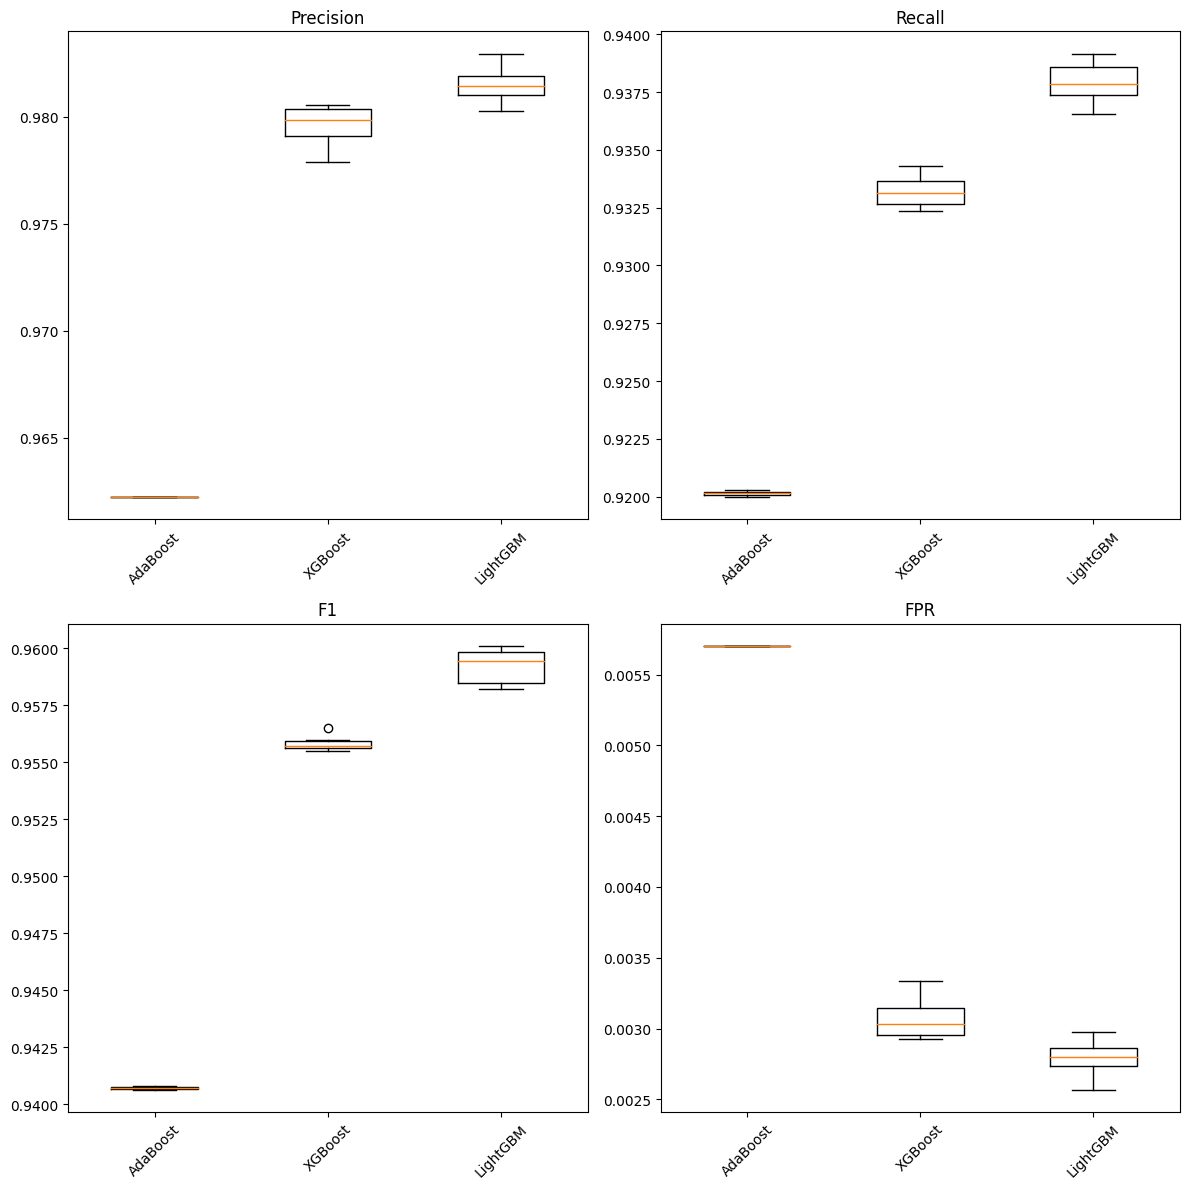

In [83]:
import copy

boosted_trees = ["AdaBoost", "XGBoost", "LightGBM"]
results_filtered = {classifier: results[classifier] for classifier in boosted_trees if classifier in results}

import numpy as np
import matplotlib.pyplot as plt

# Function to adjust the y-axis limits
def get_ylim(data_list):
    data_min = np.min(data_list)
    data_max = np.max(data_list)
    
    # Inflate the range slightly to make sure all data points are comfortably within the plot
    padding = (data_max - data_min) * 0.05
    lower = data_min - padding
    upper = data_max + padding
    
    # Ensure that the lower limit is not less than 0 since these metrics cannot be negative
    lower = max(lower, 0)
    return (lower, upper)


# Adjust the plotting function to display results for all classifiers
def plot_metric(metric, results, ax):
    data = [results[classifier][metric] for classifier in results]
    ax.boxplot(data, positions=range(1, len(results)+1), widths=0.5)
    ax.set_title(metric)
    # Set x-axis labels to classifier names
    ax.set_xticks(range(1, len(results)+1))
    ax.set_xticklabels(results.keys(), rotation=45)
    
    # Set y-axis limits
    all_data = [item for sublist in data for item in sublist]  # Flatten the list
    ax.set_ylim(*get_ylim(all_data))

    
# Display boxplots for each metric for all classifiers
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
metrics = ['Precision', 'Recall', 'F1', 'FPR']
for i, metric in enumerate(metrics):
    plot_metric(metric, results_filtered, axs[i//2, i%2])

plt.tight_layout()
plt.show()

## Boxplots for all classifiers

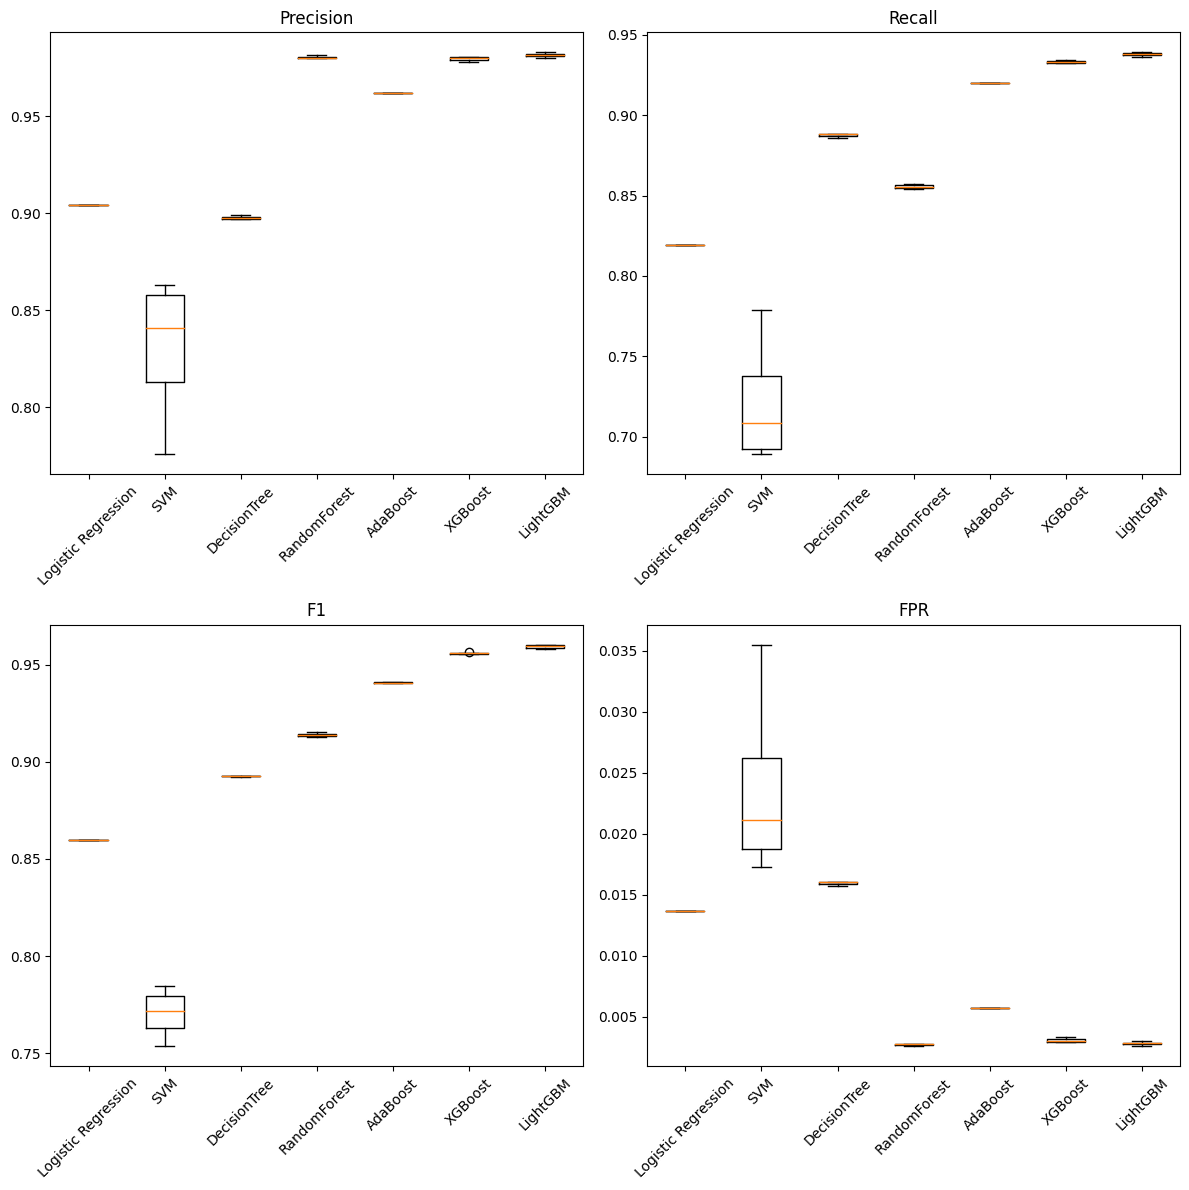

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Function to adjust the y-axis limits
def get_ylim(data_list):
    data_min = np.min(data_list)
    data_max = np.max(data_list)
    
    # Inflate the range slightly to make sure all data points are comfortably within the plot
    padding = (data_max - data_min) * 0.05
    lower = data_min - padding
    upper = data_max + padding
    
    # Ensure that the lower limit is not less than 0 since these metrics cannot be negative
    lower = max(lower, 0)
    return (lower, upper)


# Adjust the plotting function to display results for all classifiers
def plot_metric(metric, results, ax):
    data = [results[classifier][metric] for classifier in results]
    ax.boxplot(data, positions=range(1, len(results)+1), widths=0.5)
    ax.set_title(metric)
    # Set x-axis labels to classifier names
    ax.set_xticks(range(1, len(results)+1))
    ax.set_xticklabels(results.keys(), rotation=45)
    
    # Set y-axis limits
    all_data = [item for sublist in data for item in sublist]  # Flatten the list
    ax.set_ylim(*get_ylim(all_data))
    
    
# Display boxplots for each metric for all classifiers
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
metrics = ['Precision', 'Recall', 'F1', 'FPR']
for i, metric in enumerate(metrics):
    plot_metric(metric, results, axs[i//2, i%2])

plt.tight_layout()
plt.show()